# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('/datasets/gold_industry_train.csv')
df1 = pd.read_csv('/datasets/gold_industry_test.csv')
df2 = pd.read_csv('/datasets/gold_industry_full.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [5]:
for i in [df, df1, df2]:
    print(i.loc[0, :].isna().sum())

0
0
0


In [6]:
df1['date'].isna().sum()

0

In [7]:
df = df.fillna(method='ffill')
df1 = df1.fillna(method='ffill')

In [8]:
df2['rougher.output.concentrate_au'].isna().sum()

0

In [9]:
df2['final.output.concentrate_au'].isna().sum()

0

In [10]:
c = df['rougher.output.concentrate_au']
f = df['rougher.input.feed_au']
t = df['rougher.output.tail_au']

new_recovery = (c*(f - t))/(f*(c - t)) * 100
ae = abs(new_recovery - df['rougher.output.recovery'])
mae = ae.mean()
mae

9.83758577644259e-15

Получается, что столбец recovery правильный и mae между моими расчетами и таблицей = 10^-16, что в данном случае незначительно и вычисления адекватны

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4860 non-null   float64
 4   rougher.input.feed_sol                      4860 non-null   float64
 5   rougher.input.feed_rate                     4860 non-null   float64
 6   rougher.input.feed_size                     4860 non-null   float64
 7   rougher.input.floatbank10_sulfate           4860 non-null   float64
 8   rougher.input.floatbank10_xanthate          4860 non-null   float64
 9   rougher.state.floatbank10_a_air             4860 non-null   float64
 10  rougher.stat

In [12]:
count = 0
for i in df.columns:
    if i not in df1.columns:
        print(i)
        count +=1
print(count)

rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_au
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
secondary_cleaner.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.output.tail_sol
final.output.concentrate_au
final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_au
final.output.ta

В тестовом датафрейме отсутствуют все данные типа output и calculation 

In [13]:
display(
    df.duplicated().sum(),
    df1.duplicated().sum(),
    df2.duplicated().sum()
)

0

0

0

### Подитог предобработки  
имелись небольшие пропуски в исходных данных, которые заполнил методом forward fill, отсутствуют дубликаты, данные готовы к анализу  
В тестовом датафрейме отсутствуют все данные типа output и calculation, часть из которых наша модель и должна предсказывать

## Анализ данных

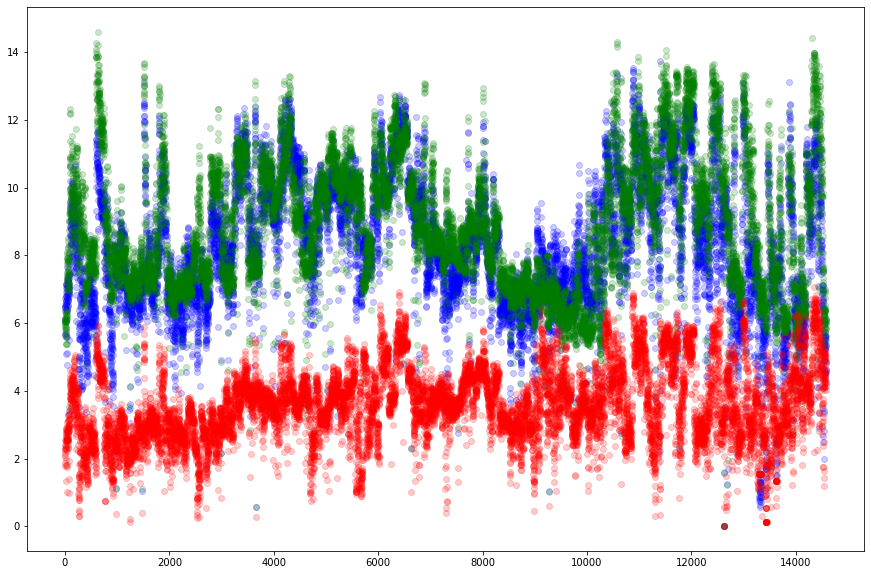

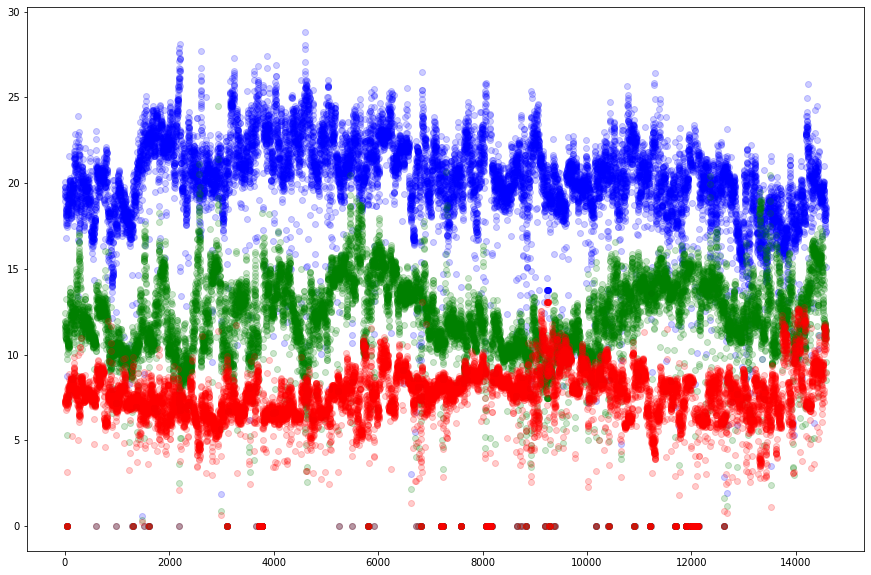

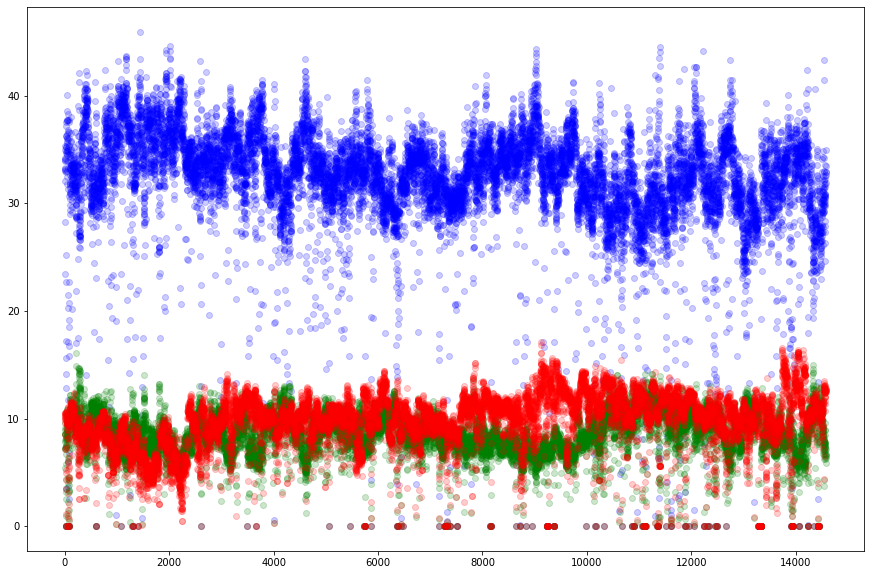

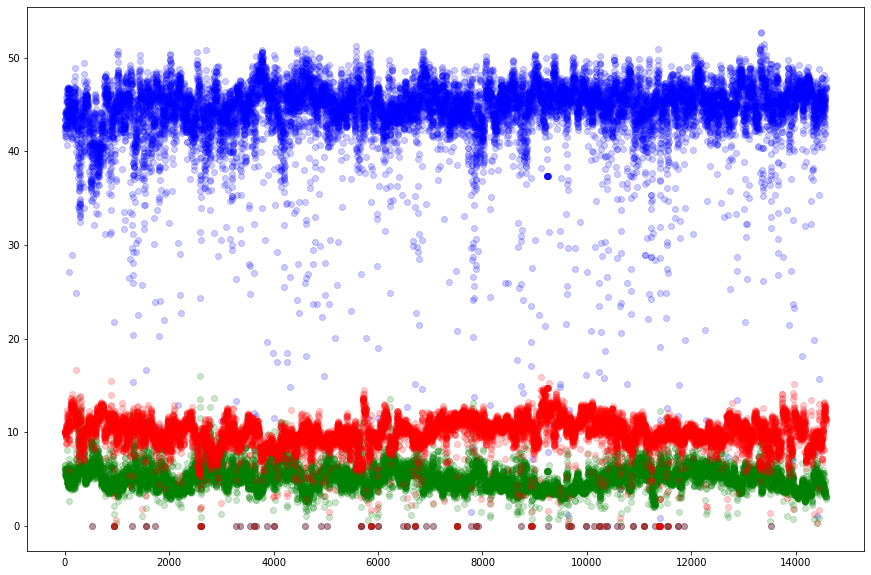

In [14]:
metals = {'au': 'blue', 'ag': 'green', 'pb': 'red'}
for method in ['rougher.input.feed_', 'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']:
    plt.figure(figsize=(15, 10))
    for metal in metals:
        column = method + metal
        plt.plot(df[column], 'o', color=metals[metal], alpha=0.2)


можно заметить, что в сырье концентрация золота и серебра примерно одинакова, а свинца меньше, после фтолации золота примерно в 2 раза больше, чем серебра, а после двух этапов очистки золота примерно 45%, когда серебра и свинца где то от 5% до 12%

### Проверим отличаются ли сильно размер гранул исходного сырья на обучающей и тестовой выборках

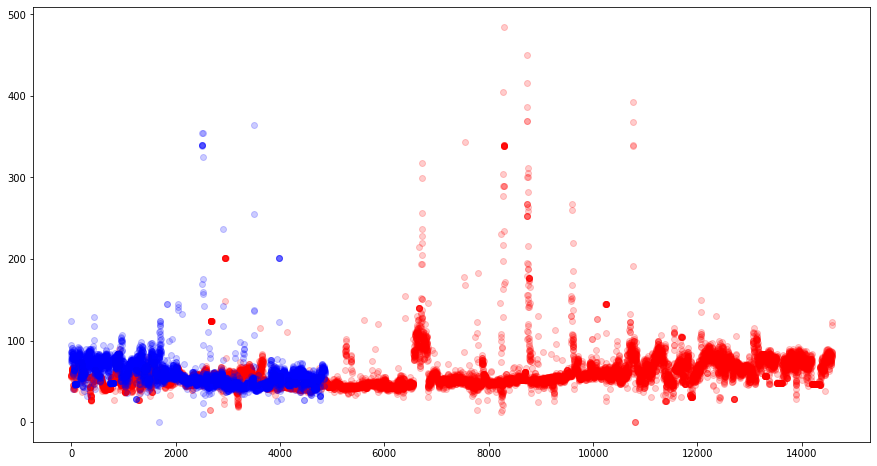

In [15]:
plt.figure(figsize=(15, 8))
plt.plot(df['rougher.input.feed_size'], 'o', color='red', alpha=0.2)
plt.plot(df1['rougher.input.feed_size'], 'o', color='blue', alpha=0.2)
plt.show()

In [16]:
print(
    len(df1['rougher.input.feed_size']), len(df['rougher.input.feed_size'])
)

4860 14579


In [17]:
ans = []
for i in range(1000):
    df_sample = df['rougher.input.feed_size'].sample(n=4860, replace=True)
    results = st.ttest_ind(df1['rougher.input.feed_size'].values, df_sample.values)
    if results.pvalue < 0.05:
        ans.append(1) ## не равны 
    else:
        ans.append(0) ## не отвергаем нулевую гипотезу

print(sum(ans)/len(ans))

0.024


In [18]:
df1['rougher.input.feed_size'].mean()

59.13615007330843

In [19]:
df['rougher.input.feed_size'].mean()

59.07086496192819

Получается, что размер гранул в тестовой и тренировочной выборок статистически одинаковый

In [20]:
metals = ['au', 'ag', 'pb']
methods = ['rougher.input.feed_', 'rougher.output.concentrate_',
           'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
for method in range(len(methods)):
    column0 = methods[method] + metals[0]
    column1 = methods[method] + metals[1]
    column2 = methods[method] + metals[2]
    
for method in range(len(methods)):
    column0 = methods[method] + metals[0]
    column1 = methods[method] + metals[1]
    column2 = methods[method] + metals[2]
    df = df[df[column0]>0]
    df = df[df[column1]>0]
    df = df[df[column2]>0]

In [21]:
df[df['primary_cleaner.output.concentrate_au'] == 0]['primary_cleaner.output.concentrate_au']

Series([], Name: primary_cleaner.output.concentrate_au, dtype: float64)

по гистограммам видно, что с каждой стадией концентрация металлов возрастает

## Модель

### Подготовим данные для построения моделей

In [22]:
features_train = df[df1.columns]
features_train = features_train.drop(['date'], axis=1)
features_train.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,11.996163,6.012594,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,11.920305,6.204633,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835,11.692450,6.196578,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,1600.449520,-500.052575,25.942508,-499.176749,23.955516,-499.848796,23.

In [23]:
target_train = df[['rougher.output.recovery', 'final.output.recovery']]

target_train.head()

,rougher.output.recovery,final.output.recovery
0,87.107763,70.541216
1,86.843261,69.266198
2,86.842308,68.116445
3,87.226430,68.347543
4,86.688794,66.927016


In [24]:
features_test = df1
features_test = features_test.drop(['date'], axis=1)

In [25]:
target_df = df2[df2['date'].isin(df1['date'])]

In [26]:
target_test = target_df[['rougher.output.recovery', 'final.output.recovery']]

target_test.head()

,rougher.output.recovery,final.output.recovery
14579,89.514960,70.281454
14580,89.858126,65.523246
14581,91.816623,74.817644
14582,88.478959,63.082720
14583,89.230316,74.463380


### Построим модели

In [27]:
def smape(pred, target):
    a = np.abs(pred - target) / ((np.abs(pred) + np.abs(target)) / 2)
    smape_score = (a.sum() / len(pred))
    return smape_score * 100


In [28]:
def final_smape(pred, target):
    smape_score = smape(pred, target)
    return (smape_score.values[1] * 0.75 + smape_score.values[0] * 0.25)

In [29]:
smape_scorer = make_scorer(final_smape)

In [30]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

scores = cross_val_score(pipeline, features_test, target_test, cv=5, scoring=smape_scorer)

print('cross validation smape:', sum(scores)/len(scores))

cross validation smape: 8.661407934702272


In [31]:
%%time

best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in [30]:
    for depth in range(2, 6):
        
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring=smape_scorer)
        avg_score = sum(scores)/len(scores)
        if avg_score < best_result:
            best_est = est
            best_depth = depth
            best_result = avg_score
print("SMAPE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)


SMAPE наилучшей модели на валидационной выборке: 8.439853118982777 Количество деревьев: 30 Максимальная глубина: 3
CPU times: user 1min 18s, sys: 71.7 ms, total: 1min 18s
Wall time: 1min 18s


In [32]:
dummy = DummyRegressor(strategy='mean')

In [33]:
scores = cross_val_score(dummy, features_train, target_train, cv=5, scoring=smape_scorer)
print('cross validation smape:', sum(scores)/len(scores))

cross validation smape: 9.367928949215237


### Подытог 
лучшей моделью оказалась линейная регрессия

## Тестрование

In [34]:
model_lin = LinearRegression()

In [35]:
model_lin.fit(features_train, target_train)
predicted_test = model_lin.predict(features_test)
f_smape = final_smape(predicted_test, target_test)
f_smape

7.133621852074986

## Итоги:
получили лучшую модель, это LinearRegression, на тестовой выборке значение smape = 7.2, когда у дамми модели среднего выходит 10.3 на кросс-валидации